In [14]:
# Name: Danyang Zhangn
# Email: daz040@eng.ucsd.edu
# PID: A53104006
PYBOLT = False
# need to remove %, ! in .py file in order to run on PYBOLT
if PYBOLT:
    from pyspark import SparkContext
    sc = SparkContext()

from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
import string
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.util import MLUtils

### Cover Type

Classify geographical locations according to their predicted tree cover:

* **URL:** http://archive.ics.uci.edu/ml/datasets/Covertype
* **Abstract:** Forest CoverType dataset
* **Data Set Description:** http://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.info

In [15]:
#define a dictionary of cover types
CoverTypes = {1.0: 'Spruce/Fir',
              2.0: 'Lodgepole Pine',
              3.0: 'Ponderosa Pine',
              4.0: 'Cottonwood/Willow',
              5.0: 'Aspen',
              6.0: 'Douglas-fir',
              7.0: 'Krummholz' 
}

if not PYBOLT:
    print 'Tree Cover Types:'
    CoverTypes

Tree Cover Types:


{1.0: 'Spruce/Fir',
 2.0: 'Lodgepole Pine',
 3.0: 'Ponderosa Pine',
 4.0: 'Cottonwood/Willow',
 5.0: 'Aspen',
 6.0: 'Douglas-fir',
 7.0: 'Krummholz'}

In [16]:
# creating a directory called covtype, download and decompress covtype.data.gz into it

if not PYBOLT:
    from os.path import exists
    if not exists('covtype'):
        print "creating directory covtype"
        !mkdir covtype
    %cd covtype
    if not exists('covtype.data'):
        if not exists('covtype.data.gz'):
            print 'downloading covtype.data.gz'
            !curl -O http://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz
        print 'decompressing covtype.data.gz'
        !gunzip -f covtype.data.gz
    !ls -l
    %cd ..

/vagrant/UCSD_BigData_2016/Solutions/HW-5/covtype
total 73408
-rw-rw-r-- 1 501 dialout 75169317 May 15 17:33 covtype.data
/vagrant/UCSD_BigData_2016/Solutions/HW-5


In [17]:
# Define the feature names
cols_txt="""
Elevation, Aspect, Slope, Horizontal_Distance_To_Hydrology,
Vertical_Distance_To_Hydrology, Horizontal_Distance_To_Roadways,
Hillshade_9am, Hillshade_Noon, Hillshade_3pm,
Horizontal_Distance_To_Fire_Points, Wilderness_Area (4 binarycolumns), 
Soil_Type (40 binary columns), Cover_Type
"""

In [18]:
# Break up features that are made out of several binary features.
cols = [string.strip(a) for a in string.split(cols_txt, ',')]
colDict={a: [a] for a in cols}
colDict['Soil_Type (40 binary columns)'] = ['ST_'+str(i) for i in range(40)]
colDict['Wilderness_Area (4 binarycolumns)'] = ['WA_'+str(i) for i in range(4)]
Columns=[]
for item in cols:
    Columns.extend(colDict[item])
    
if not PYBOLT:
    print Columns

['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'WA_0', 'WA_1', 'WA_2', 'WA_3', 'ST_0', 'ST_1', 'ST_2', 'ST_3', 'ST_4', 'ST_5', 'ST_6', 'ST_7', 'ST_8', 'ST_9', 'ST_10', 'ST_11', 'ST_12', 'ST_13', 'ST_14', 'ST_15', 'ST_16', 'ST_17', 'ST_18', 'ST_19', 'ST_20', 'ST_21', 'ST_22', 'ST_23', 'ST_24', 'ST_25', 'ST_26', 'ST_27', 'ST_28', 'ST_29', 'ST_30', 'ST_31', 'ST_32', 'ST_33', 'ST_34', 'ST_35', 'ST_36', 'ST_37', 'ST_38', 'ST_39', 'Cover_Type']


In [19]:
# Have a look at the first two lines of the data file
if not PYBOLT:
    !head -2 covtype/covtype.data

2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [27]:
# Read the file into an RDD
# If doing this on a real cluster, you need the file to be available on all nodes, ideally in HDFS.
if not PYBOLT:
    path = 'covtype/covtype.data'
else:
    path = '/covtype/covtype.data'
    
inputRDD = sc.textFile(path)
inputRDD.first()

u'2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5'

In [21]:
# Transform the text RDD into an RDD of LabeledPoints
Data=inputRDD.map(lambda line: [float(string.strip(x)) for x in line.split(',')])\
     .map(lambda p: LabeledPoint(p[-1], p[:-1]))
Data.first()
        

LabeledPoint(5.0, [2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])

In [22]:
# count the number of examples of each type
if not PYBOLT:
    total=Data.cache().count()
    print 'total data size=', total
    counts=Data.map(lambda p: (p.label, 1)).reduceByKey(lambda a, b: a+b).collect()

    counts.sort(key=lambda x: x[1], reverse=True)
    print '              type (label):   percent of total'
    print '---------------------------------------------------------'
    print '\n'.join(['%20s (%3.1f):\t%4.2f'%(CoverTypes[a[0]], a[0], 100.0*a[1]/float(total)) for a in counts])

total data size= 581012
              type (label):   percent of total
---------------------------------------------------------
      Lodgepole Pine (2.0):	48.76
          Spruce/Fir (1.0):	36.46
      Ponderosa Pine (3.0):	6.15
           Krummholz (7.0):	3.53
         Douglas-fir (6.0):	2.99
               Aspen (5.0):	1.63
   Cottonwood/Willow (4.0):	0.47


### Making the problem binary

The implementation of BoostedGradientTrees in MLLib supports only binary problems. the `CovType` problem has
7 classes. To make the problem binary we choose the `Lodgepole Pine` (label = 2.0). We therefore transform the dataset to a new dataset where the label is `1.0` is the class is `Lodgepole Pine` and is `0.0` otherwise.

$\rightarrow$ 1-vs-all

In [23]:
Label = 2.0
Data = inputRDD.map(lambda line: [float(x) for x in line.split(',')])\
       .map(lambda p: LabeledPoint(1.0 if p[-1] == Label else 0.0, p[:-1]))

### Reducing data size
In order to see the effects of overfitting more clearly, we reduce the size of the data by a factor of 10

In [24]:
# Data1, .1 data 
if not PYBOLT:
    Data1 = Data.sample(False, 0.1, seed=255).cache()
else:
    Data1 = Data.cache()
    
(trainingData, testData)=Data1.randomSplit([0.7, 0.3], seed=255)

if not PYBOLT:
    # TODO: expected output - Sizes: Data1=58022, trainingData=40674, testData=17348
    print 'Sizes: Data1=%d, trainingData=%d, testData=%d'%(Data1.count(), trainingData.cache().count(), testData.cache().count())

Sizes: Data1=58057, trainingData=40856, testData=17201


In [25]:
counts = testData.map(lambda lp: (lp.label, 1)).reduceByKey(lambda x,y: x+y).collect()
counts.sort(key=lambda x:x[1],reverse=True)
counts

[(0.0, 8927), (1.0, 8274)]

### Gradient Boosted Trees

* Following [this example](http://spark.apache.org/docs/latest/mllib-ensembles.html#gradient-boosted-trees-gbts) from the mllib documentation

* [pyspark.mllib.tree.GradientBoostedTrees documentation](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.tree.GradientBoostedTrees)

#### Main classes and methods

* `GradientBoostedTrees` is the class that implements the learning trainClassifier,
   * It's main method is `trainClassifier(trainingData)` which takes as input a training set and generates an instance of `GradientBoostedTreesModel`
   * The main parameter from train Classifier are:
      * **data** – Training dataset: RDD of LabeledPoint. Labels should take values {0, 1}.
      * categoricalFeaturesInfo – Map storing arity of categorical features. E.g., an entry (n -> k) indicates that feature n is categorical with k categories indexed from 0: {0, 1, ..., k-1}.
      * **loss** – Loss function used for minimization during gradient boosting. Supported: {“logLoss” (default), “leastSquaresError”, “leastAbsoluteError”}.
      * **numIterations** – Number of iterations of boosting. (default: 100)
      * **learningRate** – Learning rate for shrinking the contribution of each estimator. The learning rate should be between in the interval (0, 1]. (default: 0.1)
      * **maxDepth** – Maximum depth of the tree. E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 3)
      * **maxBins** – maximum number of bins used for splitting features (default: 32) DecisionTree requires maxBins >= max categories
      
      
* `GradientBoostedTreesModel` represents the output of the boosting process: a linear combination of classification trees. The methods supported by this class are:
   * `save(sc, path)` : save the tree to a given filename, sc is the Spark Context.
   * `load(sc,path)` : The counterpart to save - load classifier from file.
   * `predict(X)` : predict on a single datapoint (the `.features` field of a `LabeledPont`) or an RDD of datapoints.
   * `toDebugString()` : print the classifier in a human readable format.

In [26]:
from time import time
errors = {}

if not PYBOLT:
    depths = [1, 3, 6, 10, 15, 20]
else:
    depths = [15]

for depth in depths:
    start = time()
    model = GradientBoostedTrees.trainClassifier(trainingData, {}, maxDepth=depth, numIterations=10)
    # numIterations is the numTrees
    #print model.toDebugString()
    
    errors[depth] = {}
    dataSets = {'train': trainingData, 'test': testData}
    for name in dataSets.keys():  # Calculate errors on TRAIN and TEST sets
        data = dataSets[name]
        Predicted = model.predict(data.map(lambda x: x.features))  
        LabelsAndPredictions = data.map(lambda x: x.label).zip(Predicted)
        Err = LabelsAndPredictions.filter(lambda (v, p): v != p).count()/float(data.count())  # zip
        errors[depth][name] = Err
    if not PYBOLT:
        print depth, errors[depth], int(time()-start), 'seconds'
    else:
        print depth, errors[depth]

if not PYBOLT:
    print errors

1 {'test': 0.27998372187663506, 'train': 0.2777560211474447} 11 seconds
3 {'test': 0.2521946398465206, 'train': 0.25061190522811827} 13 seconds
6 {'test': 0.21330155223533515, 'train': 0.20569806148423733} 12 seconds
10 {'test': 0.17219929073891052, 'train': 0.1324897199921676} 22 seconds
15 {'test': 0.14063135864193943, 'train': 0.02890640297630703} 90 seconds
20 {'test': 0.1430149409918028, 'train': 0.0011993342471118074} 211 seconds
{1: {'test': 0.27998372187663506, 'train': 0.2777560211474447}, 3: {'test': 0.2521946398465206, 'train': 0.25061190522811827}, 6: {'test': 0.21330155223533515, 'train': 0.20569806148423733}, 10: {'test': 0.17219929073891052, 'train': 0.1324897199921676}, 15: {'test': 0.14063135864193943, 'train': 0.02890640297630703}, 20: {'test': 0.1430149409918028, 'train': 0.0011993342471118074}}


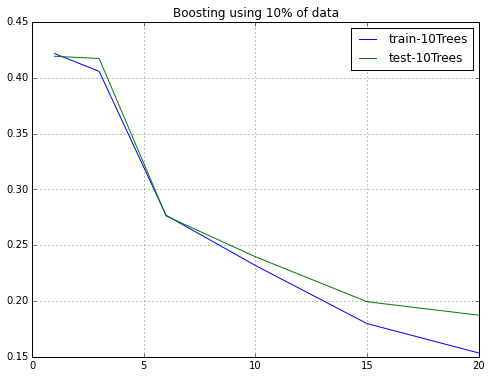

In [34]:
if not PYBOLT:
    B10 = errors

    # Plot Train/test accuracy vs Depth of trees graph
    %matplotlib inline
    from plot_utils import *
    make_figure([B10], ['10Trees'], Title='Boosting using 10% of data')

### Random Forests

* Following [this example](http://spark.apache.org/docs/latest/mllib-ensembles.html#classification) from the mllib documentation

* [pyspark.mllib.trees.RandomForest documentation](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.tree.RandomForest)

**trainClassifier**`(data, numClasses, categoricalFeaturesInfo, numTrees, featureSubsetStrategy='auto', impurity='gini', maxDepth=4, maxBins=32, seed=None)`   
Method to train a decision tree model for binary or multiclass classification.

**Parameters:**  
* *data* – Training dataset: RDD of LabeledPoint. Labels should take values {0, 1, ..., numClasses-1}.  
* *numClasses* – number of classes for classification.  
* *categoricalFeaturesInfo* – Map storing arity of categorical features. E.g., an entry (n -> k) indicates that feature n is categorical with k categories indexed from 0: {0, 1, ..., k-1}.  
* *numTrees* – Number of trees in the random forest.  
* *featureSubsetStrategy* – Number of features to consider for splits at each node. Supported: “auto” (default), “all”, “sqrt”, “log2”, “onethird”. If “auto” is set, this parameter is set based on numTrees: if numTrees == 1, set to “all”; if numTrees > 1 (forest) set to “sqrt”.
* *impurity* – Criterion used for information gain calculation. Supported values: “gini” (recommended) or “entropy”.  
* *maxDepth* – Maximum depth of the tree. E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 4)  
* *maxBins* – maximum number of bins used for splitting features (default: 32)
* *seed* – Random seed for bootstrapping and choosing feature subsets.  

**Returns:**	
RandomForestModel that can be used for prediction

In [29]:
if not PYBOLT:
    from time import time
    from pyspark.mllib.tree import RandomForest
    errors={}
    for depth in [1, 3, 6, 10, 15, 20]:
        start=time()
        model = RandomForest.trainClassifier(trainingData, 2, {}, maxDepth=depth, numTrees=10)
        #print model.toDebugString()
        errors[depth]={}
        dataSets={'train':trainingData,'test':testData}
        for name in dataSets.keys():  # Calculate errors on train and test sets
            data = dataSets[name]
            Predicted = model.predict(data.map(lambda x: x.features))  
            LabelsAndPredictions = data.map(lambda x: x.label).zip(Predicted)
            Err = LabelsAndPredictions.filter(lambda (v, p): v != p).count()/float(data.count())  # zip
            errors[depth][name] = Err

        print depth,errors[depth],int(time()-start),'seconds'
    print errors

1 {'test': 0.41927794895645604, 'train': 0.4217006070099863} 2 seconds
3 {'test': 0.41730131969071566, 'train': 0.4057910710789113} 2 seconds
6 {'test': 0.2762048718097785, 'train': 0.27677697278245544} 3 seconds
10 {'test': 0.23963723039358176, 'train': 0.23183865282944977} 4 seconds
15 {'test': 0.19934887506540316, 'train': 0.17975327981202271} 5 seconds
20 {'test': 0.18731469100633685, 'train': 0.15346583121206187} 9 seconds
{1: {'test': 0.41927794895645604, 'train': 0.4217006070099863}, 3: {'test': 0.41730131969071566, 'train': 0.4057910710789113}, 6: {'test': 0.2762048718097785, 'train': 0.27677697278245544}, 10: {'test': 0.23963723039358176, 'train': 0.23183865282944977}, 15: {'test': 0.19934887506540316, 'train': 0.17975327981202271}, 20: {'test': 0.18731469100633685, 'train': 0.15346583121206187}}


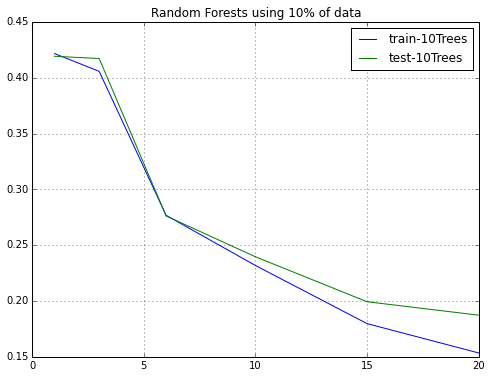

In [32]:
if not PYBOLT:
    RF_10trees = errors
    # Plot Train/test accuracy vs Depth of trees graph
    make_figure([RF_10trees], ['10Trees'], Title='Random Forests using 10% of data')

### Now plot B10 and RF_10trees performance curves in the same graph

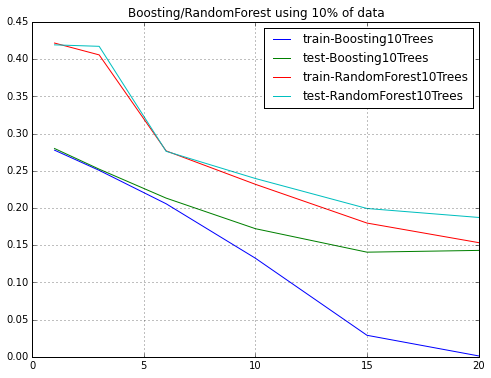

In [33]:
if not PYBOLT:
    make_figure([B10, RF_10trees], ['Boosting10Trees', 'RandomForest10Trees'], 
                Title='Boosting/RandomForest using 10% of data')